<a href="https://colab.research.google.com/github/Marrtinerz/ML-DS-Projects/blob/main/Project_2_Rain_Prediction_in_Australia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> Rain Prediction in Australia Using Classification Models </h1>


## Problem Context
The Australian government is trying to forecast the weather to aid businesses and individuals effectively plan their activities.
## Question Statements
1. Will it rain on a certain day?
2. How accurate is the answer provided for **question 1**?

<h2>Table of contents</h2>


1. [About the data](#about_data)
2. [Data analysis/pre-processing](#preprocessing)
3. [Modeling](#modeling)
4. [Evaluation](#evaluation)
5. [Result and Insights](#results)
6. [Conclusions](#conclusions)


<h2 id="about_data">
  About the data
</h2>

Importing the required libraries:

In [ ]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, accuracy_score, jaccard_score, f1_score, precision_score, recall_score, log_loss, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
import sklearn.metrics as metrics
import sqlite3
%matplotlib inline
mpl.style.use(['ggplot'])

<h3>Data source</h3>

- The original source of the data is Australian Government's Bureau of Meteorology and the latest data can be gathered from [http://www.bom.gov.au/climate/dwo/](http://www.bom.gov.au/climate/dwo/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2022-01-01).

- The dataset to be used has extra columns like 'RainToday' and the target attribute is "RainTomorrow," which was gathered from the Rattle at [https://bitbucket.org/kayontoga/rattle/src/master/data/weatherAUS.RData](https://bitbucket.org/kayontoga/rattle/src/master/data/weatherAUS.RData?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2022-01-01)


- This dataset contains observations of weather metrics for each day from 2008 to 2017. It includes 22 fields and 3271 observations.

<h3>Database Creation and Data Loading</h3>

In [ ]:
# Establishing sqlite3 database connection and cursor objects
conn = sqlite3.connect("Project_3.db")
cur = conn.cursor()

# Loading sql magic and connecting to the Project_3.DB database

%load_ext sql

%sql sqlite:///Project_3.db

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [ ]:
#downloading the dataset and loading to the database
url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillUp/labs/ML-FinalAssignment/Weather_Data.csv"
df = pd.read_csv(url)
df.to_sql("Weather_Data", conn, if_exists = "replace", index = False, method = "multi")

3271

In [ ]:
# retrieving the created tables from the database as a confirmation
%sql SELECT name FROM sqlite_master where type='table';

 * sqlite:///Project_3.db
Done.


name
Weather_Data


<h4>Querying the Database and Loading the data to Pandas</h4>

In [ ]:
#retrieving a list of the columns from a table for reference

%sql PRAGMA table_info([Weather_Data]);

 * sqlite:///Project_3.db
Done.


cid,name,type,notnull,dflt_value,pk
0,Date,TEXT,0,None,0
1,MinTemp,REAL,0,None,0
2,MaxTemp,REAL,0,None,0
3,Rainfall,REAL,0,None,0
4,Evaporation,REAL,0,None,0
5,Sunshine,REAL,0,None,0
6,WindGustDir,TEXT,0,None,0
7,WindGustSpeed,INTEGER,0,None,0
8,WindDir9am,TEXT,0,None,0
9,WindDir3pm,TEXT,0,None,0


In [ ]:
# retrieving the first 10 observations from the database
%sql SELECT * from Weather_Data LIMIT 10;

 * sqlite:///Project_3.db
Done.


Date,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
2/1/2008,19.5,22.4,15.6,6.2,0.0,W,41,S,SSW,17,20,92,84,1017.6,1017.4,8,8,20.7,20.9,Yes,Yes
2/2/2008,19.5,25.6,6.0,3.4,2.7,W,41,W,E,9,13,83,73,1017.9,1016.4,7,7,22.4,24.8,Yes,Yes
2/3/2008,21.6,24.5,6.6,2.4,0.1,W,41,ESE,ESE,17,2,88,86,1016.7,1015.6,7,8,23.5,23.0,Yes,Yes
2/4/2008,20.2,22.8,18.8,2.2,0.0,W,41,NNE,E,22,20,83,90,1014.2,1011.8,8,8,21.4,20.9,Yes,Yes
2/5/2008,19.7,25.7,77.4,4.8,0.0,W,41,NNE,W,11,6,88,74,1008.3,1004.8,8,8,22.5,25.5,Yes,Yes
2/6/2008,20.2,27.2,1.6,2.6,8.6,W,41,W,ENE,9,22,69,62,1002.7,998.6,6,6,23.8,26.0,Yes,Yes
2/7/2008,18.6,26.3,6.2,5.2,5.2,W,41,W,S,15,15,75,80,999.0,1000.3,4,7,21.7,22.3,Yes,Yes
2/8/2008,17.2,22.3,27.6,5.8,2.1,W,41,S,SE,7,15,77,61,1008.3,1007.4,7,8,18.9,21.1,Yes,Yes
2/9/2008,16.4,20.8,12.6,4.8,3.0,W,41,SSW,W,19,9,92,91,1006.4,1007.6,7,7,17.1,16.5,Yes,Yes
2/10/2008,14.6,24.2,8.8,4.4,10.1,W,41,W,SSE,11,20,80,53,1014.0,1013.4,4,2,17.2,23.3,Yes,No


In [ ]:
# retrieving the absolute frequencies of the rainy and non-rainy days
%sql SELECT RainToday, COUNT(RainToday) FROM Weather_Data GROUP BY RainToday;

 * sqlite:///Project_3.db
Done.


RainToday,COUNT(RainToday)
No,2422
Yes,849


In [ ]:
#retrieving analysis data from the database to a pandas dataframe.
data = %sql SELECT * FROM Weather_Data;
rain_df = pd.DataFrame(data)

 * sqlite:///Project_3.db
Done.


In [ ]:
#closing the sql connection

conn.close()

<h2 id="preprocessing">
  Data analysis/pre-processing
</h2>

<h3> Exploratory Data Analysis</h3>

In [ ]:
#Viewing the first 5 observations in the dataframe
rain_df.head()

,Date,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2/1/2008,19.5,22.4,15.6,6.2,0.0,W,41,S,SSW,...,92,84,1017.6,1017.4,8,8,20.7,20.9,Yes,Yes
1,2/2/2008,19.5,25.6,6.0,3.4,2.7,W,41,W,E,...,83,73,1017.9,1016.4,7,7,22.4,24.8,Yes,Yes
2,2/3/2008,21.6,24.5,6.6,2.4,0.1,W,41,ESE,ESE,...,88,86,1016.7,1015.6,7,8,23.5,23.0,Yes,Yes
3,2/4/2008,20.2,22.8,18.8,2.2,0.0,W,41,NNE,E,...,83,90,1014.2,1011.8,8,8,21.4,20.9,Yes,Yes
4,2/5/2008,19.7,25.7,77.4,4.8,0.0,W,41,NNE,W,...,88,74,1008.3,1004.8,8,8,22.5,25.5,Yes,Yes


In [ ]:
#Obtaining summary statistics of the data
rain_df.describe(include="all")

,Date,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
count,3271,3271.000000,3271.000000,3271.000000,3271.000000,3271.000000,3271,3271.000000,3271,3271,...,3271.000000,3271.000000,3271.000000,3271.000000,3271.000000,3271.000000,3271.000000,3271.000000,3271,3271
unique,3271,NaN,NaN,NaN,NaN,NaN,16,NaN,16,16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2
top,2/1/2008,NaN,NaN,NaN,NaN,NaN,W,NaN,W,E,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,No
freq,1,NaN,NaN,NaN,NaN,NaN,1425,NaN,1260,624,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2422,2422
mean,NaN,14.877102,23.005564,3.342158,5.175787,7.168970,NaN,41.476307,NaN,NaN,...,68.243962,54.698563,1018.334424,1016.003085,4.318557,4.176093,17.821461,21.543656,NaN,NaN
std,NaN,4.554710,4.483752,9.917746,2.757684,3.815966,NaN,10.806951,NaN,NaN,...,15.086127,16.279241,7.020090,7.019915,2.526923,2.411274,4.894316,4.297053,NaN,NaN
min,NaN,4.300000,11.700000,0.000000,0.000000,0.000000,NaN,17.000000,NaN,NaN,...,19.000000,10.000000,986.700000,989.800000,0.000000,0.000000,6.400000,10.200000,NaN,NaN
25%,NaN,11.000000,19.600000,0.000000,3.200000,4.250000,NaN,35.000000,NaN,NaN,...,58.000000,44.000000,1013.700000,1011.300000,2.000000,2.000000,13.800000,18.400000,NaN,NaN
50%,NaN,14.900000,22.800000,0.000000,4.800000,8.300000,NaN,41.000000,NaN,NaN,...,69.000000,56.000000,1018.600000,1016.300000,5.000000,4.000000,18.200000,21.300000,NaN,NaN
75%,NaN,18.800000,26.000000,1.400000,7.000000,10.200000,NaN,44.000000,NaN,NaN,...,80.000000,64.000000,1023.100000,1020.800000,7.000000,7.000000,21.700000,24.500000,NaN,NaN


**At a glance**
- From 2008 to 2017, there were more dry days than rainy days.
- The dominant prediction for the labeled target field $RainTomorrow$ is "No."
- The temperature extremes ranged from $4.3^0-45.80^0C$ during the examined period.
- There are apparantly days with 0.00 mm of rainfall, which begs scrutiny.

<h4>Temperature Distribution</h4>

Text(0.5, 0, 'Temperature ($\\mathregular{^{0}C}$)')

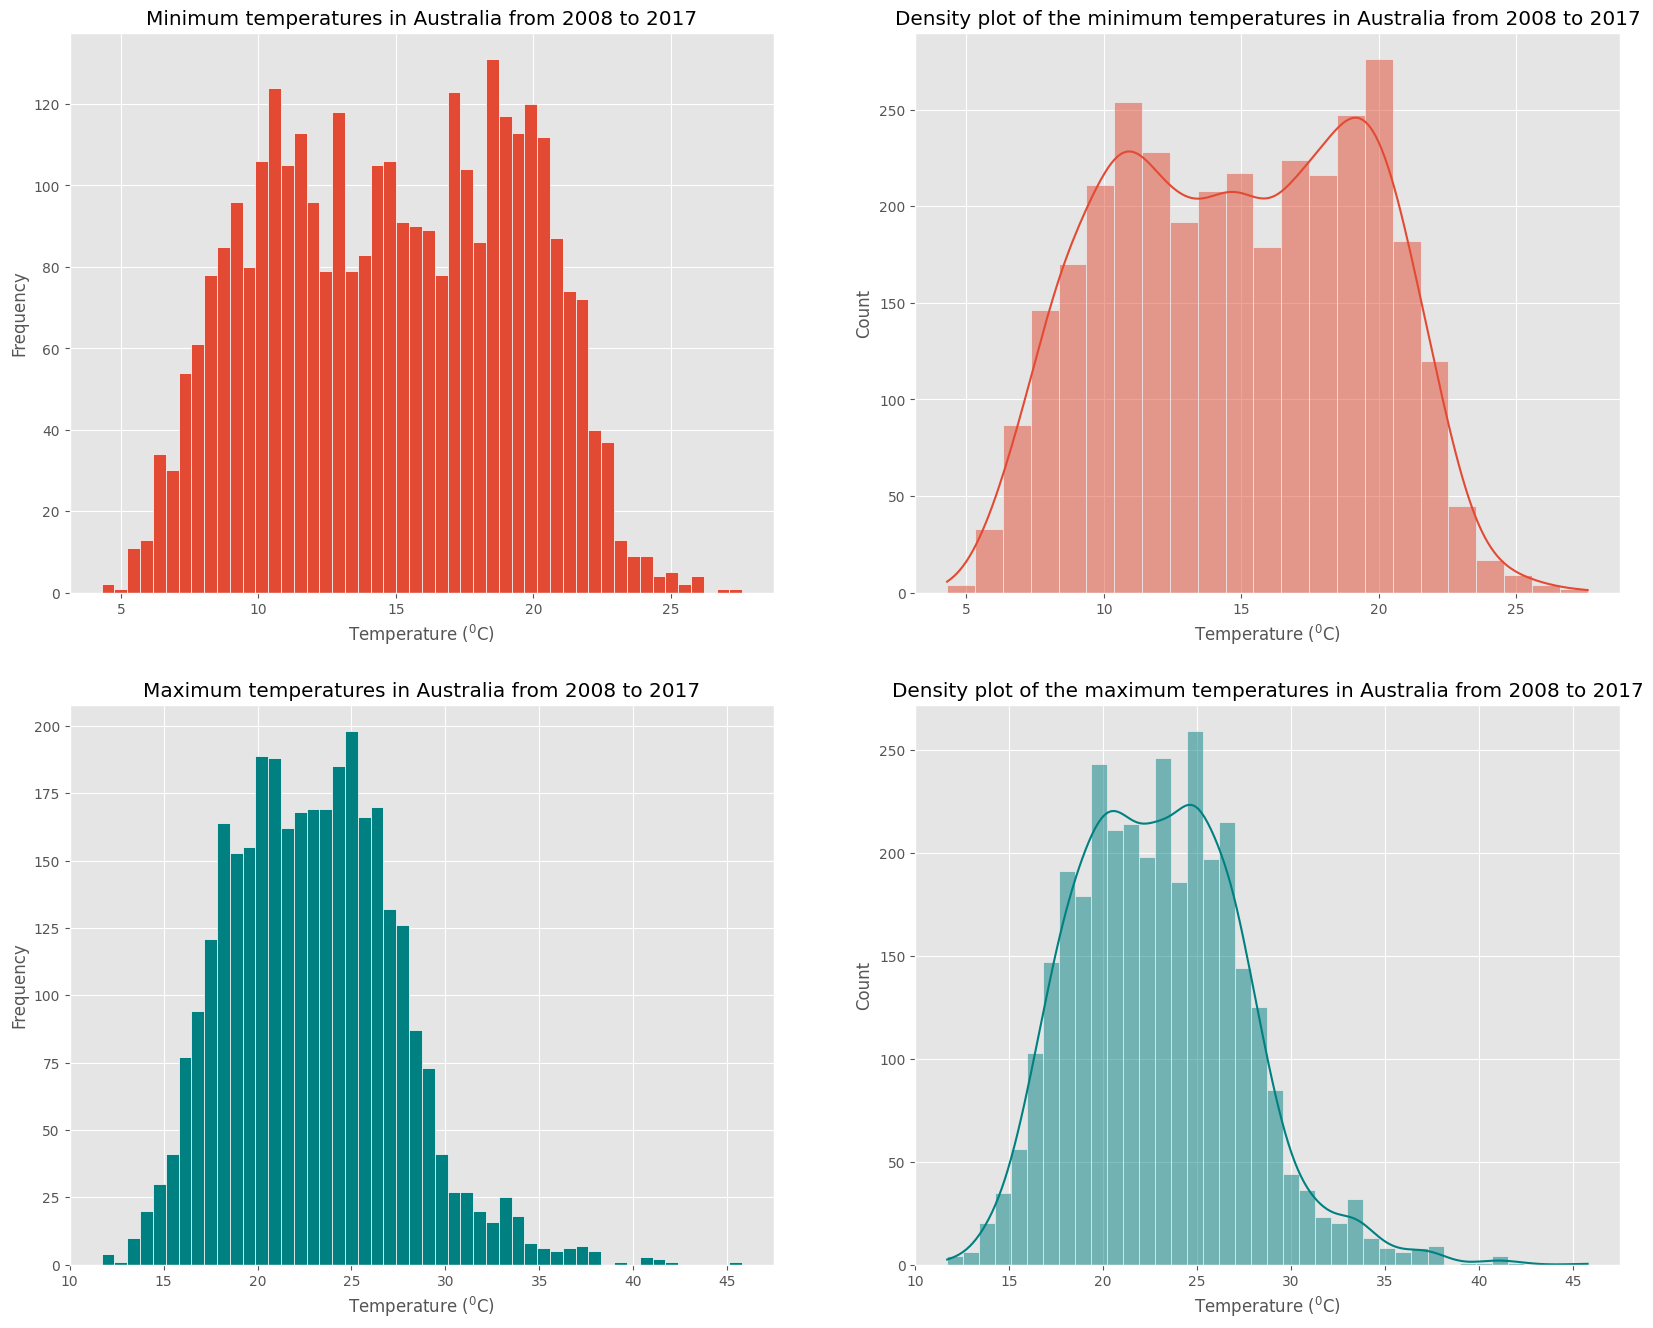

In [ ]:
fig = plt.figure(figsize=(20, 16))
ax0 = fig.add_subplot(2, 2, 1)
ax1 = fig.add_subplot(2, 2, 2)
ax2 = fig.add_subplot(2, 2, 3)
ax3 = fig.add_subplot(2, 2, 4)

#temperature histogram distribution
temperature_df = pd.concat([rain_df["MinTemp"], rain_df["MaxTemp"]])
rain_df["MinTemp"].plot(kind="hist", bins = 50, ax=ax0, edgecolor = 'white')
#ax0.set_ylim(0, 2500)
ax0.set_title("Minimum temperatures in Australia from 2008 to 2017")
ax0.set_ylabel("Frequency")
ax0.set_xlabel("Temperature ($\mathregular{^{0}C}$)")

#density distribution
sns.histplot(rain_df["MinTemp"].values, kde=True, ax=ax1)
ax1.set_title("Density plot of the minimum temperatures in Australia from 2008 to 2017")
ax1.set_xlabel("Temperature ($\mathregular{^{0}C}$)")


rain_df["MaxTemp"].plot(kind="hist", bins = 50, ax=ax2, edgecolor = 'white', color="teal")
#ax0.set_ylim(0, 2500)
ax2.set_title("Maximum temperatures in Australia from 2008 to 2017")
ax2.set_ylabel("Frequency")
ax2.set_xlabel("Temperature ($\mathregular{^{0}C}$)")

#density distribution
sns.histplot(rain_df["MaxTemp"].values, kde=True, ax=ax3, color="teal")
ax3.set_title("Density plot of the maximum temperatures in Australia from 2008 to 2017")
ax3.set_xlabel("Temperature ($\mathregular{^{0}C}$)")

Text(0, 0.5, 'Values ($\\mathregular{^{0}C}$)')

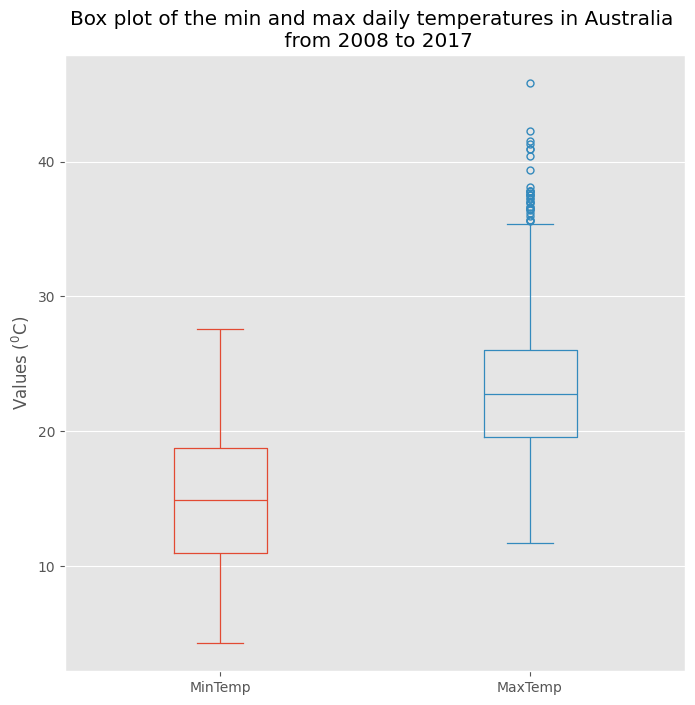

In [ ]:
#box plot for the temperature to display outliers
plt.figure(figsize=(8, 8))

temp_df = rain_df[["MinTemp", "MaxTemp"]]

sns.boxplot(temp_df, width=0.3, fill=False, linewidth=0.9, fliersize=5)
plt.title("Box plot of the min and max daily temperatures in Australia \n from 2008 to 2017")
plt.ylabel("Values ($\mathregular{^{0}C}$)")

<h4>Rainfall Amount</h4>

([<matplotlib.axis.XTick at 0x7aef07c37190>,
 [Text(2008, 0, '2008'),
  Text(2009, 0, '2009'),
  Text(2010, 0, '2010'),
  Text(2011, 0, '2011'),
  Text(2012, 0, '2012'),
  Text(2013, 0, '2013'),
  Text(2014, 0, '2014'),
  Text(2015, 0, '2015'),
  Text(2016, 0, '2016'),
  Text(2017, 0, '2017')])

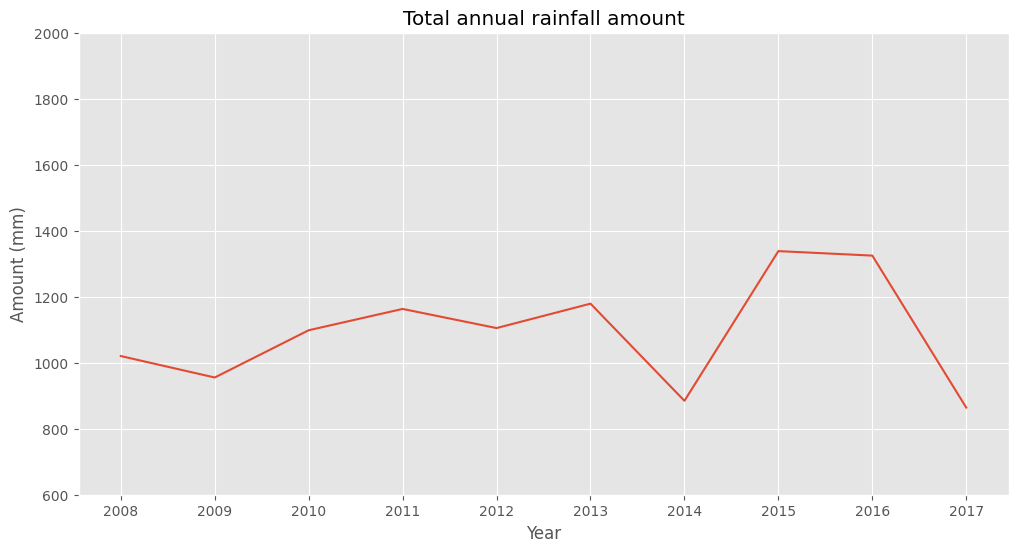

In [ ]:
#retrieving the year from the data column
df["date"] = pd.to_datetime(rain_df["Date"], format="mixed")
df["year"]= df["date"].dt.year
df["year"]

#Adding the year column to the df to group the annual rainfall amount
rain_df2 = rain_df
rain_df2["year"] = df["year"]
new_rain_df = rain_df2.groupby(["year"]).sum(numeric_only=True)
xticks = list(range(2008, 2018))

#lineplot showing the annual rainfall amount
plt.figure(figsize=(12, 6))
sns.lineplot(data=new_rain_df, x="year", y="Rainfall")
plt.title("Total annual rainfall amount")
plt.ylabel("Amount (mm)")
plt.xlabel("Year")
plt.ylim(600, 2000)
plt.xticks(ticks=xticks)

As shown in the image above, the lowest amount of rainfall was recorded in 2017, whereas the highest amount was recorded in 2015.

<h3>Cleaning/Preprocessing</h3>

<h4> Outliers & Missing Values</h4>

In [ ]:
#Checking the datatypes for missing values
rain_df.isnull().sum()

Date             0
MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
RainTomorrow     0
year             0
dtype: int64

There are no missing values.

<h4>One-Hot encoding</h4>

Since some of the variables are categorical, we need to convert them into binary/dummy variables.

In [ ]:
#Converting the categorical independent variables into dummy variables. This would split each of the affected columns into two.
rain_df_processed = pd.get_dummies(data=rain_df, columns=['RainToday', 'WindGustDir', 'WindDir9am', 'WindDir3pm'])

#Converting the $Rain_Tomorrow$ target field from a categorical field (yes/no) to a binary field (0s and 1s).
rain_df_processed["RainTomorrow"].replace(["No", "Yes"], [0,1], inplace=True)

In [ ]:
rain_df_processed.RainTomorrow.value_counts()

RainTomorrow
0    2422
1     849
Name: count, dtype: int64

<h4>Dropping columns and setting data types</h4>

In [ ]:
#dropping the data column, since it's not needed here.
rain_df_processed.drop('Date', axis=1, inplace=True)

#Converting all Dtypes to float for the analyses and to avoid information loss.
rain_df_processed = rain_df_processed.astype(float)
rain_df_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3271 entries, 0 to 3270
Data columns (total 68 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   MinTemp          3271 non-null   float64
 1   MaxTemp          3271 non-null   float64
 2   Rainfall         3271 non-null   float64
 3   Evaporation      3271 non-null   float64
 4   Sunshine         3271 non-null   float64
 5   WindGustSpeed    3271 non-null   float64
 6   WindSpeed9am     3271 non-null   float64
 7   WindSpeed3pm     3271 non-null   float64
 8   Humidity9am      3271 non-null   float64
 9   Humidity3pm      3271 non-null   float64
 10  Pressure9am      3271 non-null   float64
 11  Pressure3pm      3271 non-null   float64
 12  Cloud9am         3271 non-null   float64
 13  Cloud3pm         3271 non-null   float64
 14  Temp9am          3271 non-null   float64
 15  Temp3pm          3271 non-null   float64
 16  RainTomorrow     3271 non-null   float64
 17  year          

<h4>Separation of feature and target sets</h4>

In [ ]:
# Separting the features
features = rain_df_processed.drop("RainTomorrow", axis=1)
target = rain_df_processed["RainTomorrow"]

<h2 id="modeling">
  Modeling
</h2>

<h3>Train/Test Data Split</h3>

In [ ]:
#splitting the data into training and test sets(20% test and 80% train)
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=10)
print(x_train.shape)
print(x_test.shape)

(2616, 67)
(655, 67)


<h3>1. Linear Regression</h3>

<h4>Model building and training</h4>

In [ ]:
#Creating a linear Regression model and fitting using the training data
LinearReg = LinearRegression().fit(x_train, y_train)
LinearReg

LinearRegression()

<h4>Predictions on the test data</h4>

In [ ]:
#using the created model for predictions with the test data
LinearReg_predictions = LinearReg.predict(x_test)
LinearReg_predictions[:5]

array([0.13232115, 0.27691091, 0.97681922, 0.28737185, 0.13557124])

<h4>Model evaluation</h4>

In [ ]:
#finding the mean absolute error, mean squared error, and r2 score of the model
LinearReg_MAE = mean_absolute_error(y_test, LinearReg_predictions)
LinearReg_MSE = mean_squared_error(y_test, LinearReg_predictions)
LinearReg_R2 = r2_score(y_test, LinearReg_predictions)

#showing the report
LinearReg_Report = pd.DataFrame({"LinearRegression_MAE": [LinearReg_MAE], "LinearRegression_MSE": [LinearReg_MSE], "LinearRegression_R2": [LinearReg_R2]}, index=None)
LinearReg_Report

,LinearRegression_MAE,LinearRegression_MSE,LinearRegression_R2
0,0.256239,0.115705,0.42721


<h3>2. K-Nearest Neighbors</h3>

<h4>Model building and training</h4>

In [ ]:
#creating a KNN model and fitting using the training data
KNN = KNeighborsClassifier(n_neighbors=4).fit(x_train, y_train)
KNN

KNeighborsClassifier(n_neighbors=4)

<h4>Predictions on the test data</h4>

In [ ]:
KNN_predictions = KNN.predict(x_test)
KNN_predictions[:5]

array([0., 0., 1., 0., 0.])

<h4>Model evaluation</h4>

In [ ]:
#obtaining the f1 score, accuracy score and Jaccard index

KNN_Accuracy_Score = accuracy_score(y_test, KNN_predictions)
KNN_JaccardIndex = jaccard_score(y_test, KNN_predictions)
KNN_F1_Score = f1_score(y_test, KNN_predictions)

#showing the report
KNN_report = pd.DataFrame({"Accuracy Score": [KNN_Accuracy_Score], "Jaccard Index": [KNN_JaccardIndex], "F1 Score": [KNN_F1_Score]})
KNN_report

,Accuracy Score,Jaccard Index,F1 Score
0,0.819847,0.435407,0.606667


<h5><b>Confusion matrix</b></h5>

In [ ]:
#function for plotting the confusion matrix using a heatmap
def plot_cf_matrix(cf, plot_title, f1_score, cmap):
  group_counts = ["{0:0.0f}".format(value) for value in
                  cf.flatten()]
  group_percentages = ["{0:.2%}".format(value) for value in
                      cf.flatten()/np.sum(cf)]
  #list comprehension
  labels = [f"{v1}\n{v2}" for v1, v2 in
            zip(group_counts,group_percentages)]
  #reshaping the labels into a 2,2 matrix to fit the confusion matrix
  labels = np.asarray(labels).reshape(2,2)
  #plotting the matrix
  plt.figure(figsize=(10, 6))
  sns.heatmap(cf, annot=labels, fmt='', cmap=cmap)
  plt.title(f"\n{plot_title}\n")
  plt.xlabel("Predicted label \n\n F1 score = {:.3f}\n\n".format(f1_score))
  plt.ylabel("True label")
  plt.show()

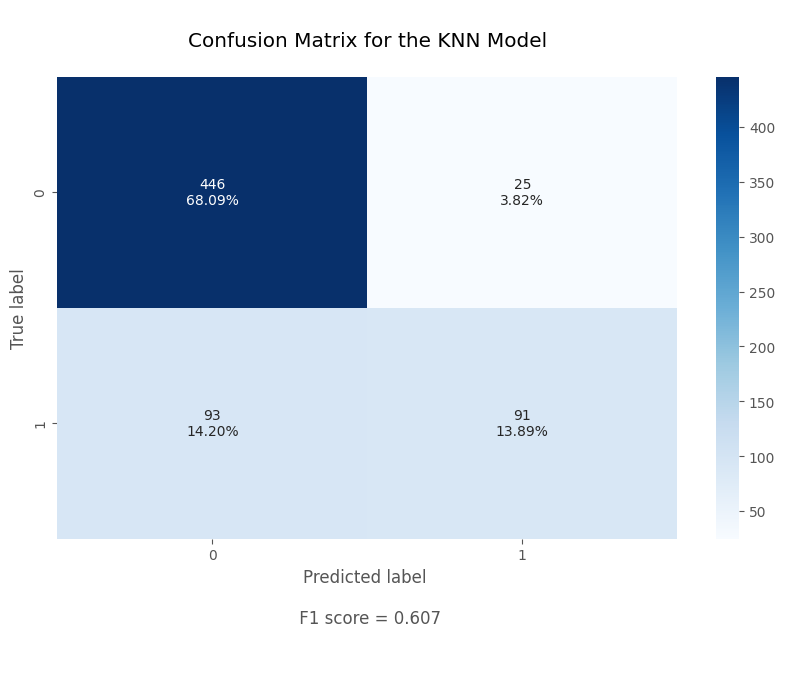

In [ ]:
cf_matrix_KNN = confusion_matrix(y_test, KNN_predictions)

matrix_KNN = plot_cf_matrix(cf=cf_matrix_KNN, plot_title="Confusion Matrix for the KNN Model", f1_score = KNN_F1_Score, cmap="Blues")
matrix_KNN

<h3>3. Decision Tree</h3>

<h4>Model building and training</h4>

In [ ]:
#creating a Decision Tree model and fitting using the training data
Tree = DecisionTreeClassifier(criterion="entropy", max_depth=4)
Tree.fit(x_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=4)

<h4>Predictions on the test data</h4>

In [ ]:
Tree_predictions = Tree.predict(x_test)
Tree_predictions[:5]

array([0., 0., 1., 0., 0.])

<h4>Model evaluation</h4>

In [ ]:
#obtaining the f1 score, accuracy score and Jaccard index

Tree_Accuracy_Score = accuracy_score(y_test, Tree_predictions)
Tree_JaccardIndex = jaccard_score(y_test, Tree_predictions)
Tree_F1_Score = f1_score(y_test, Tree_predictions)

#showing the report
Tree_report = pd.DataFrame({"Accuracy Score": [Tree_Accuracy_Score], "Jaccard Index": [Tree_JaccardIndex], "F1 Score": [Tree_F1_Score]})
Tree_report

,Accuracy Score,Jaccard Index,F1 Score
0,0.819847,0.473214,0.642424


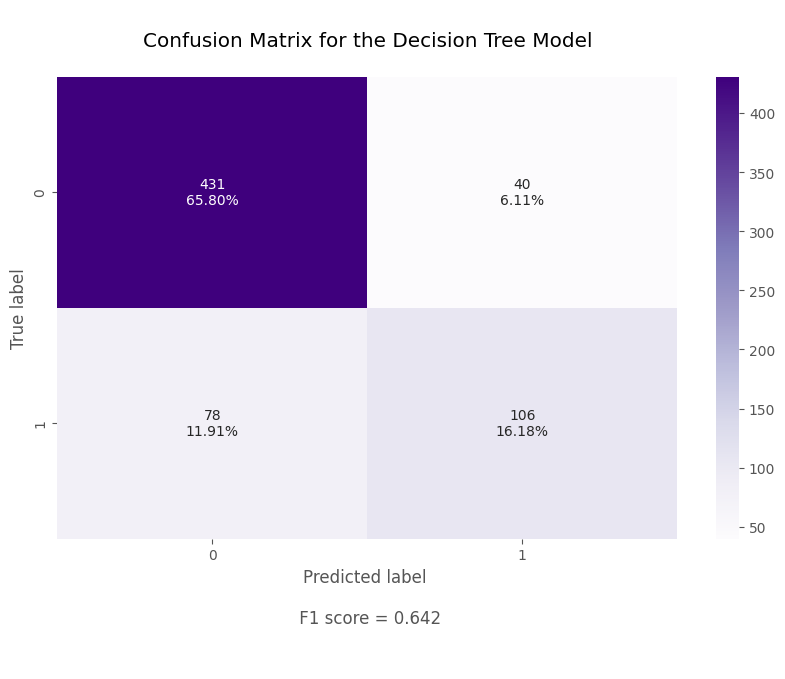

In [ ]:
#confusion matrix
cf_matrix_Tree = confusion_matrix(y_test, Tree_predictions)

matrix_Tree = plot_cf_matrix(cf=cf_matrix_Tree, plot_title="Confusion Matrix for the Decision Tree Model", f1_score = Tree_F1_Score, cmap="Purples")
matrix_Tree

<h3>4. Logistic Regression</h3>

In [ ]:
#trying different, random train/test datasets (using a differnt random_state).
x_train2, x_test2, y_train2, y_test2 = train_test_split(features, target, test_size = 0.15, random_state = 1)

<h4>Model building and training</h4>

In [ ]:
#creating a Logistic Regression model and fitting using the training data
LR = LogisticRegression(C=1, solver="liblinear")
LR.fit(x_train2, y_train2)

LogisticRegression(C=1, solver='liblinear')

<h4>Predictions on the test data</h4>

In [ ]:
log_predictions = LR.predict(x_test2)
print(log_predictions[:5])

#predicting the probabilities
log_probapredictions = LR.predict_proba(x_test2)
log_probapredictions[:5]

[0. 0. 0. 0. 0.]


array([[0.75008319, 0.24991681],
       [0.97812843, 0.02187157],
       [0.53923686, 0.46076314],
       [0.81828452, 0.18171548],
       [0.97398959, 0.02601041]])

<h4>Model evaluation</h4>

In [ ]:
#obtaining the f1 score, accuracy score and Jaccard index
from sklearn.metrics import log_loss
log_accuracy_score = accuracy_score(y_test2, log_predictions)
log_jaccardindex = jaccard_score(y_test2, log_predictions)
log_f1_Score = f1_score(y_test2, log_predictions)
logloss = log_loss(y_test2, log_probapredictions)

#showing the report
Logreg_report = pd.DataFrame({"Accuracy Score": [log_accuracy_score], "Jaccard Index": [log_jaccardindex], "F1 Score": [log_f1_Score], "Log Loss": [logloss]})
Logreg_report

,Accuracy Score,Jaccard Index,F1 Score,Log Loss
0,0.845214,0.525,0.688525,0.362846


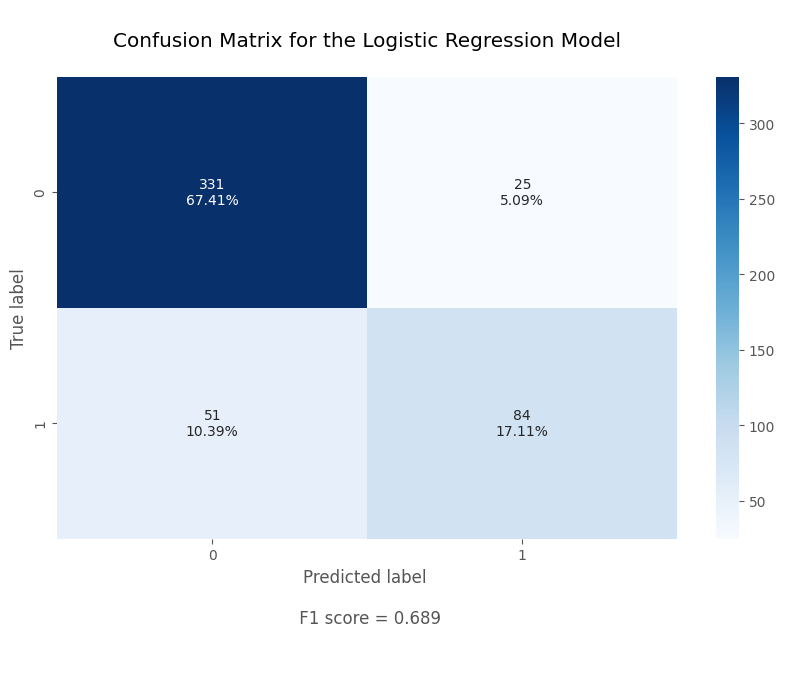

In [ ]:
#confusion matrix
cf_matrix_Log = confusion_matrix(y_test2, log_predictions)

matrix_Log = plot_cf_matrix(cf=cf_matrix_Log, plot_title="Confusion Matrix for the Logistic Regression Model", f1_score = log_f1_Score, cmap="Blues")
matrix_Log

<h3>5. Support Vector Machine</h3>

<h4>Model building and training</h4>

In [ ]:
#creating a support vector classifier and fitting using the training data
SVM = svm.SVC(kernel="rbf")
SVM.fit(x_train2, y_train2)

SVC()

<h4>Predictions on the test data</h4>

In [ ]:
svm_predictions = SVM.predict(x_test2)
#print(svm_predictions[:5])
svm_predictions[:5]

array([0., 0., 0., 0., 0.])

<h4>Model evaluation</h4>

In [ ]:
#obtaining the f1 score, accuracy score and Jaccard index
svm_accuracy_score = accuracy_score(y_test2, svm_predictions)
svm_jaccardindex = jaccard_score(y_test2, svm_predictions)
svm_f1_Score = f1_score(y_test2, svm_predictions)

#showing the report
SVM_report = pd.DataFrame({"Accuracy Score": [svm_accuracy_score], "Jaccard Index": [svm_jaccardindex], "F1 Score": [svm_f1_Score]})
SVM_report

,Accuracy Score,Jaccard Index,F1 Score
0,0.725051,0.0,0.0


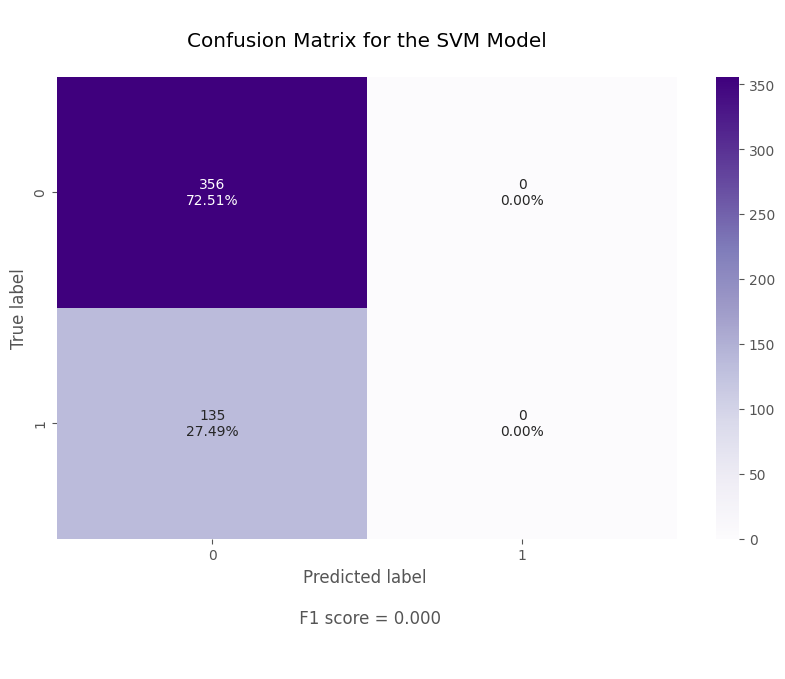

In [ ]:
#confusion matrix
cf_matrix_svm = confusion_matrix(y_test2, svm_predictions)

matrix_svm = plot_cf_matrix(cf=cf_matrix_svm, plot_title="Confusion Matrix for the SVM Model", f1_score = svm_f1_Score, cmap="Purples")
matrix_svm

<h2 id="results">
  Result and Insights
</h2>

<h3>Comparing the models' performances</h3>

In [ ]:
Report = pd.concat([KNN_report, Tree_report, Logreg_report, SVM_report], axis=0, ignore_index = True)
Report["Model"] = ["KNN", "DT", "LogRes", "SVM"]
Report.set_index("Model", inplace=True)
Report

,Accuracy Score,Jaccard Index,F1 Score,Log Loss
Model,,,,
KNN,0.819847,0.435407,0.606667,NaN
DT,0.819847,0.473214,0.642424,NaN
LogRes,0.845214,0.525000,0.688525,0.362846
SVM,0.725051,0.000000,0.000000,NaN


Text(0, 0.5, 'Score')

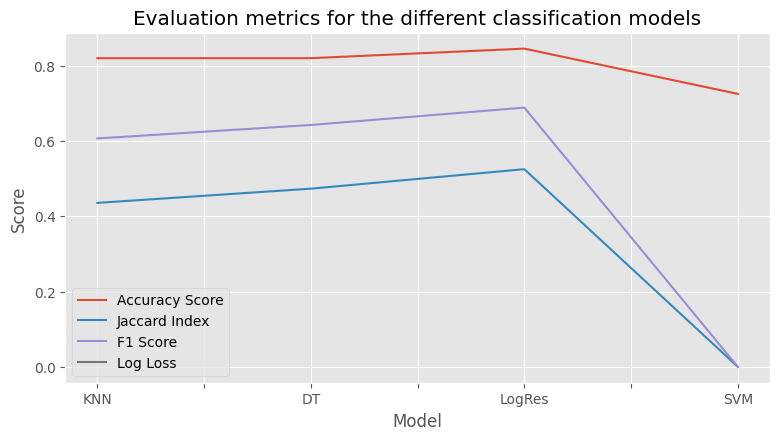

In [ ]:
#mpl.style.use(['ggplot'])

fig = plt.figure()

#Creating the different axes for the subplots
ax0 = fig.add_subplot(2, 2, 1)
#ax1 = fig.add_subplot(2,2, 2)
#ax2 = fig.add_subplot(2, 2, 3)
#ax3 = fig.add_subplot(2, 2, 4)

#accuracy score line plot
Report.plot(kind="line", ax=ax0, figsize=(20, 10))
ax0.set_title("Evaluation metrics for the different classification models")
ax0.set_ylabel("Score")

As shown in the image above, the Logistic Regression model exhibits the best accuracy score, jaccard index, and f1 score. This indicates that it would provide the best rain prediction performance.

<h2 id="conclusions">
  Conclusions
</h2>

- The logistic model exhibits the best accuracy for predicting rainfall in Australia on any given day.
- The prediction accuracy is approximately 84%, which is a good percentage.
- Businesses and individuals can plan their activities based on the predictions provided by the model in this study.

<h3>Author: <a href="mailto:mnnamchi@gmail.com">Martins Nnamchi</a></h3>